# Algorithms for Threat Detection Data
By Zhonghao Zhao and Bingxue An, under advise of Professor Bo Li

In [1]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math
import warnings
warnings.filterwarnings('ignore')
import sys
!{sys.executable} -m pip install pandas-profiling
import pandas_profiling

In [33]:
# read data
data_number = [1,2,3]
dataset = pd.read_csv("DATA/"+ "AIS_Challenge_Problem_Set_0_"+ str(1) + "_withVID.csv")
dataset_2 = pd.read_csv("DATA/"+ "AIS_Challenge_Problem_Set_0_"+ str(2) + "_withVID.csv")
dataset_3 = pd.read_csv("DATA/"+ "AIS_Challenge_Problem_Set_0_"+ str(1) + "_withVID.csv")
dataset.info()
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 7 columns):
OBJECT_ID             13714 non-null int64
VID                   13714 non-null int64
SEQUENCE_DTTM         13714 non-null object
LAT                   13714 non-null float64
LON                   13714 non-null float64
SPEED_OVER_GROUND     13714 non-null int64
COURSE_OVER_GROUND    13714 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 750.1+ KB


,OBJECT_ID,VID,SEQUENCE_DTTM,LAT,LON,SPEED_OVER_GROUND,COURSE_OVER_GROUND
0,1,100008,14:00:00,36.906850,-76.089022,1,1641
1,2,100015,14:00:00,36.950000,-76.026834,11,2815
2,3,100016,14:00:00,36.906783,-76.089084,0,2632
3,4,100019,14:00:00,37.003000,-76.283167,148,2460
4,5,100016,14:00:01,36.906783,-76.089084,0,2632


In [34]:
#check whether there is missing values in the data
dataset.isnull().sum()

OBJECT_ID             0
VID                   0
SEQUENCE_DTTM         0
LAT                   0
LON                   0
SPEED_OVER_GROUND     0
COURSE_OVER_GROUND    0
dtype: int64

In [35]:
#summary of the data
#pandas_profiling.ProfileReport(dataset)

In [36]:
# A method to convert HH-MM-SS to seconds
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

# a node class for each data
class Vessel_node:
    def __init__(self, object_id, time, lat, lon, speed, direction, real_VID):
        self.OBJECT_ID = object_id
        self.VID = -1
        self.Time = time
        self.LAT = lat
        self.LON = lon
        self.Speed = speed*0.514444
        self.Direction = direction
        self.real_vid = real_VID
    
    def set_VID(self, vid):
        self.VID = vid
    
    def get_ID(self):
        return self.OBJECT_ID
    
    def get_real_vid(self):
        return self.real_vid
    
    def get_LAT(self):
        return self.LAT
    
    def get_LON(self):
        return self.LON
    
    def get_Time(self):
        return self.Time
    
    def get_SPEED(self):
        return self.Speed
    
    def get_DIRECTION(self):
        return self.Direction
    
# a track class to keep all tracks
class All_tracks:
    def __init__(self):
        self.tracks = []
        self.total_track = 0
        self.node_tracks = []
    
    def get_total_track(self):
        return self.total_track
        
    def add_track(self, node):
        new_track = [node.get_ID()]
        new_node_track = [node]
        self.total_track += 1
        node.set_VID(self.total_track)
        self.tracks.append(new_track)
        self.node_tracks.append(new_node_track) 
     
    def add_node(self, track_id, node):
        node.set_VID(track_id)
        self.tracks[track_id - 1].append(node.get_ID())
        self.node_tracks[track_id - 1].append(node)
    
    def print_track(self):
        for track in self.tracks:
            print(track)
            print('\n')
        
    def print_track_number(self):
        print(self.total_track)
    
    def get_node_track(self):
        return self.node_tracks
    
    def get_track_number(self):
        return self.total_track
    
    def get_tracks(self):
        return self.tracks

In [8]:
'''The initial assumption is the accleration is constant between two nodes, use v_1-v_0 / (t_1-t_0) to calculate 
the accleration, use v_0*t + 0.5*a*t^2 to calculate the desired final x, y location, then compare it with the final 
x, y location, calculate the desired distance difference sqrt (x_expect-x)^2 + (y_expect-y)^2 for every track, compare
it with the actual distane, using actual lon and lat to calculate
'''
def calculate_distance(lat2, lon2, lat1, lon1):
    R = 6371000; #earth radian
    l_1 = math.radians(lat1)
    l_2 = math.radians(lat2)
    lat_diff = math.radians(lat2-lat1)
    lon_diff = math.radians(lon2-lon1)
    temp = math.sin(lat_diff/2)**2 + math.cos(l_1) * math.cos(l_2) * math.sin(lon_diff/2)**2
    c = 2 * math.atan2(math.sqrt(temp), math.sqrt(1-temp))
    d = R * c
    return d

vid = []
train_tracker = All_tracks()
errors = []
outcome = []
for index, row in dataset.iterrows():
    a = row.tolist()
    node = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10, a[1])
    cur_vid = a[1]
    node_tracks = train_tracker.get_node_track()
    if cur_vid not in vid:
        cur_errors = []
        if vid:
            for i in range(train_tracker.get_track_number()):
                cur_track = node_tracks[i]
                last = cur_track[-1]
                if(last.get_Time() == node.get_Time()):
                    continue
                a = last
                b = node
                angle_1 = math.radians(a.get_DIRECTION())
                angle_2 = math.radians(b.get_DIRECTION())
                v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
                v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
                t_diff = b.get_Time()- a.get_Time()
                acc_x = v_diff_x / t_diff
                acc_y = v_diff_y / t_diff
                lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
                lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
                total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
                d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
                error = (abs(d)-abs(total_diff))**2
                cur_errors.append(error)
            
        train_tracker.add_track(node)
        vid.append(cur_vid)
        if cur_errors:
            errors.append(min(cur_errors))
            outcome.append(1)
        
    else:
        for i in range(train_tracker.get_track_number()):
            cur_track = node_tracks[i]
            last = cur_track[-1]
            if(last.get_real_vid() == cur_vid):
                train_tracker.add_node(i+1, node)
            else:
                continue
            a = last
            b = node
            angle_1 = math.radians(a.get_DIRECTION())
            angle_2 = math.radians(b.get_DIRECTION())
            v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
            v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
            t_diff = b.get_Time()- a.get_Time()
            acc_x = v_diff_x / t_diff
            acc_y = v_diff_y / t_diff
            lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
            lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
            total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
            d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
            error = (abs(d)-abs(total_diff))**2
            errors.append(error)
            outcome.append(0)
            
print(len(errors))
print(len(outcome))

13710
13710


In [15]:
#k fold cross validation, k = 10
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
X = errors
y = outcome
kf = KFold(n_splits=10)
kf.get_n_splits(X)
KFold(n_splits=10, random_state=None, shuffle=False)
decision_scores = []
best_dicision = 0
randomForest_scores = []
best_randomForest = 0
logistic_scores = []
best_logistic = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = [[X[i]] for i in train_index], [[X[i]] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
    
    #decision tree
    dec = DecisionTreeClassifier()
    dec = dec.fit(X_train,y_train)
    y_pred_d = dec.predict(X_test)
    current_score_d = metrics.accuracy_score(y_test, y_pred_d)
    if not decision_scores or current_score_d > max(decision_scores):
        best_dicision = dec
    decision_scores.append(current_score_d)
    
    #random forest
    ran = RandomForestClassifier(n_estimators=10)
    ran = ran.fit(X_train,y_train)
    y_pred_r = ran.predict(X_test)
    current_score_r = metrics.accuracy_score(y_test, y_pred_r)
    if not randomForest_scores or current_score_r > max(randomForest_scores):
        best_randomForest = ran
    randomForest_scores.append(current_score_r)
    
    #logistic regression
    logreg = LogisticRegression()
    logreg = logreg.fit(X_train,y_train)
    y_pred=logreg.predict(X_test)
    current_score_l = metrics.accuracy_score(y_test, y_pred)
    if not logistic_scores or current_score_l > max(decision_scores):
        best_logistic = logreg
    logistic_scores.append(current_score_l)
    

print(decision_scores)
print(randomForest_scores)
print(logistic_scores)


[0.9934354485776805, 0.9992706053975201, 0.9956236323851203, 0.9992706053975201, 0.9992706053975201, 0.9992706053975201, 1.0, 0.9992706053975201, 1.0, 0.9985412107950401]
[0.9934354485776805, 0.9992706053975201, 0.9963530269876003, 0.9992706053975201, 1.0, 0.9992706053975201, 1.0, 0.9992706053975201, 1.0, 0.9985412107950401]
[0.9934354485776805, 0.9992706053975201, 0.9941648431801605, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [16]:
def Average(lst): 
    return sum(lst) / len(lst) 

print(Average(decision_scores))
print(Average(randomForest_scores))
print(Average(logistic_scores))

0.998395331874544
0.9985412107950401
0.9986870897155361


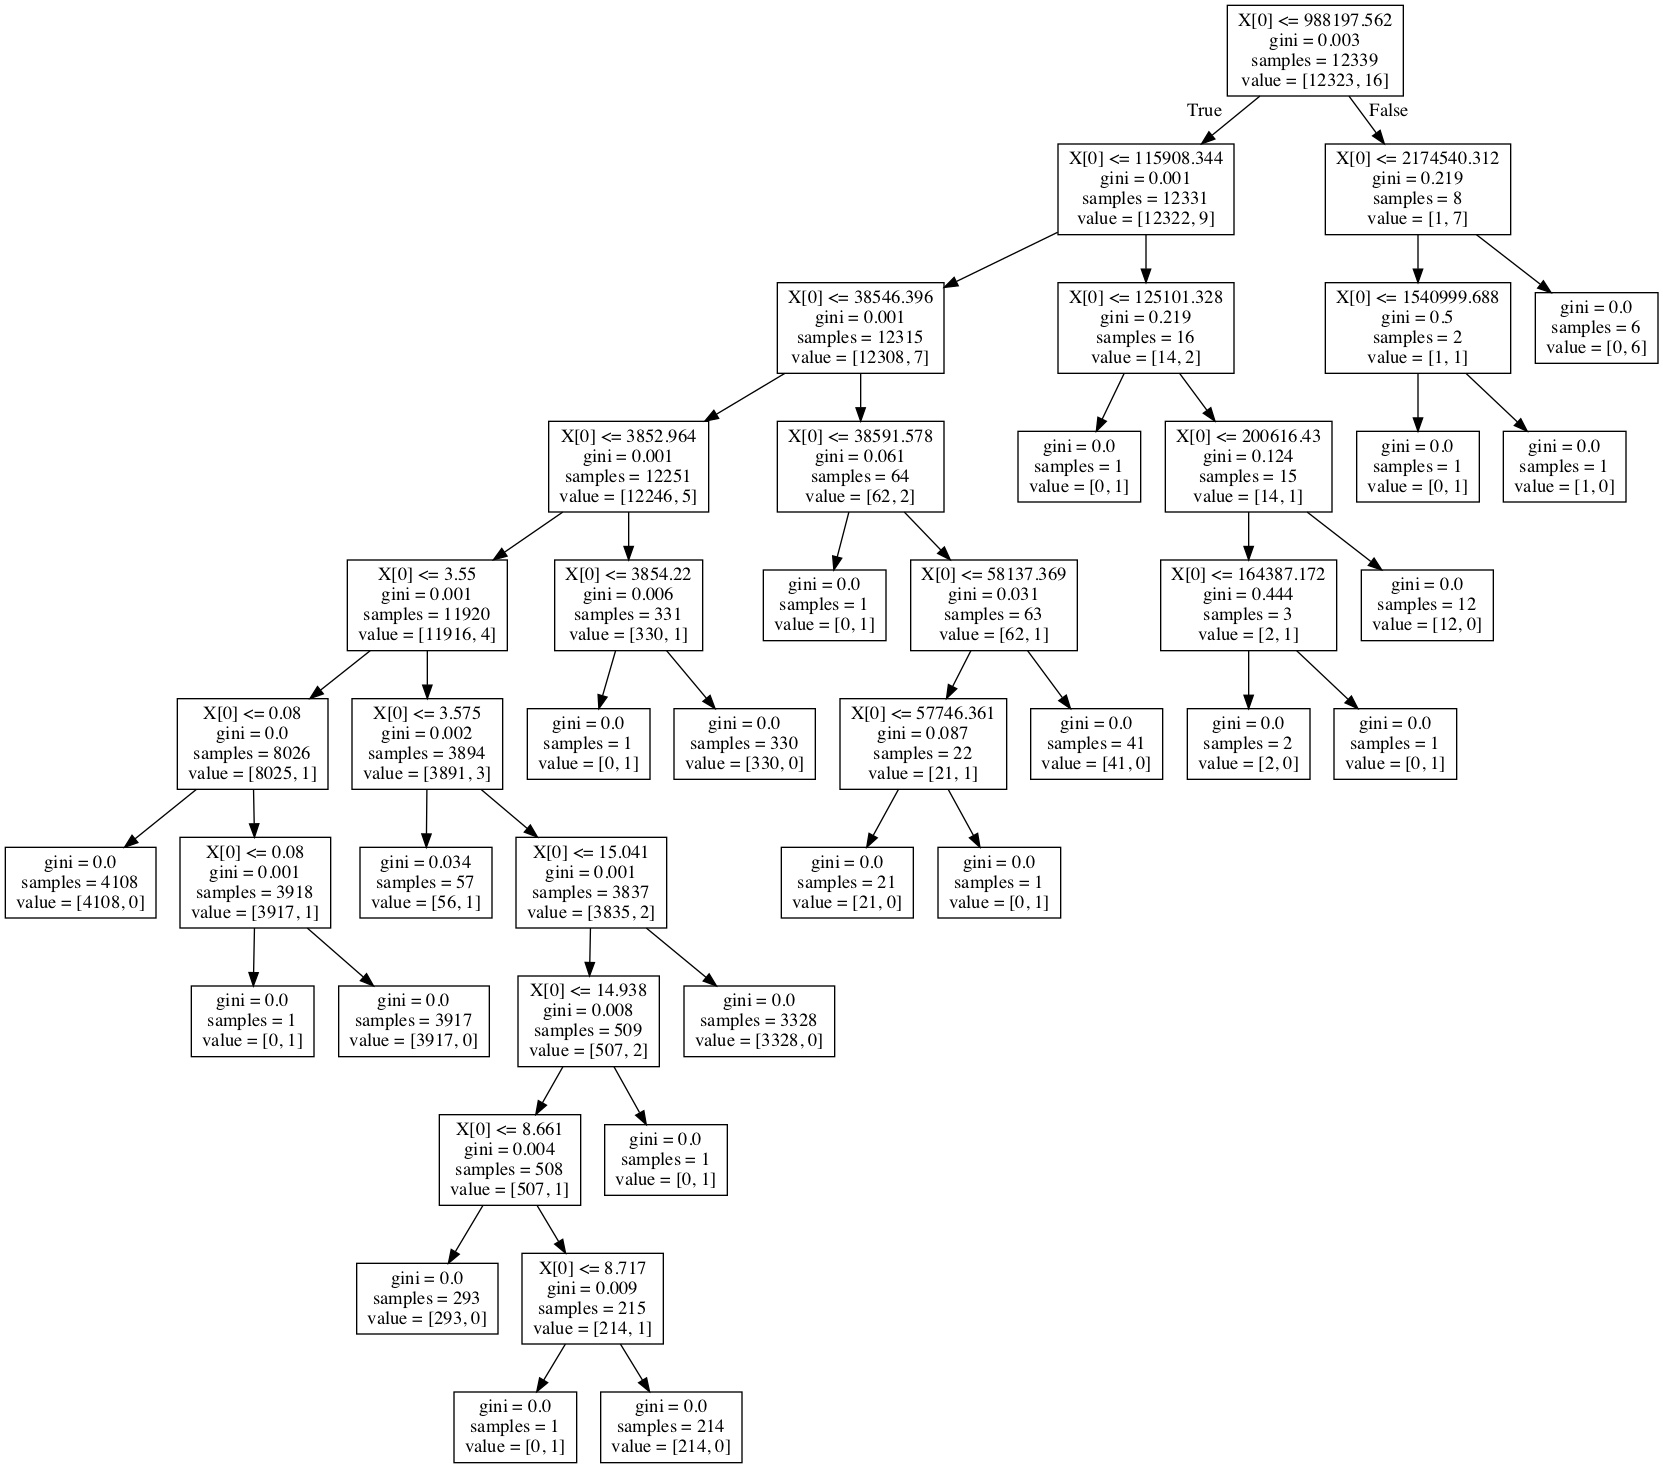

In [35]:
#visualize decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(best_dicision, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [48]:
#group process algorithm
def sortSecond(val): 
    return val[1]  

total_rows = len(dataset_3.index)
new_tracker = All_tracks()
count = 0
temp_queue = []
temp_vid = []
for index, row in dataset_3.iterrows():
    a = row.tolist()
    node = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10,a[1])
    count += 1
    if count == 1:
        new_tracker.add_track(node)
    else:
        if count > 6:
            temp_queue.append(node)
        track_id = -1
        temp_errors = []
        node_tracks = new_tracker.get_node_track()
        for i in range(new_tracker.get_track_number()):
            each_track = node_tracks[i]
            if(each_track[-1].get_Time() == node.get_Time()):
                continue
            else:
                a = each_track[-1]
                b = node
                angle_1 = math.radians(a.get_DIRECTION())
                angle_2 = math.radians(b.get_DIRECTION())
                v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
                v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
                t_diff = b.get_Time()- a.get_Time()
                acc_x = v_diff_x / t_diff
                acc_y = v_diff_y / t_diff
                lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
                lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
                total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
                d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
                error = (abs(d)-abs(total_diff))**2
                temp_errors.append((i+1, error))
        if not temp_errors:
            new_tracker.add_track(node);
        else:
            temp_errors.sort(key = sortSecond)
            split = best_logistic.predict([[temp_errors[0][1]]])
            if not split:
                track_id = temp_errors[0][0] 
            if(track_id == -1):
                if count <= 6:
                    new_tracker.add_track(node)
                else:
                    temp_vid.append(-1)
            else:
                if count <= 6:
                    new_tracker.add_node(track_id, node)
                else:
                    temp_vid.append(track_id)
    
    if len(temp_queue) == 6 or count == total_rows:
        for z in range(len(temp_queue)):
            node = temp_queue[z]
            K = 3
            node_tracks = new_tracker.get_node_track()
            all_neighbors = []
            for i in range(new_tracker.get_track_number()):
                each_track = node_tracks[i]
                for j in range(1,K+1): 
                    if(len(each_track) > j-1):
                        if(each_track[-j].get_Time() == node.get_Time()):
                            continue
                        else:
                            a = each_track[-j]
                            b = node
                            angle_1 = math.radians(a.get_DIRECTION())
                            angle_2 = math.radians(b.get_DIRECTION())
                            v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
                            v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
                            t_diff = b.get_Time()- a.get_Time()
                            acc_x = v_diff_x / t_diff
                            acc_y = v_diff_y / t_diff
                            lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
                            lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
                            total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
                            d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
                            error = (abs(d)-abs(total_diff))**2
                            all_neighbors.append((i+1, error))
            for i in range(z+1,len(temp_queue)):
                if(temp_queue[i].get_Time() == node.get_Time()):
                    continue
                else:
                    a = temp_queue[i]
                    b = node
                    angle_1 = math.radians(a.get_DIRECTION())
                    angle_2 = math.radians(b.get_DIRECTION())
                    v_diff_x = b.get_SPEED()*math.cos(angle_2) - a.get_SPEED()*math.cos(angle_1)
                    v_diff_y = b.get_SPEED()*math.sin(angle_2) - a.get_SPEED()*math.sin(angle_1)
                    t_diff = b.get_Time()- a.get_Time()
                    acc_x = v_diff_x / t_diff
                    acc_y = v_diff_y / t_diff
                    lon_diff_expect = a.get_SPEED()*math.cos(angle_1)*t_diff + 0.5*acc_x*t_diff**2
                    lat_diff_expect = a.get_SPEED()*math.sin(angle_1)*t_diff + 0.5*acc_y*t_diff**2
                    total_diff = math.sqrt(lon_diff_expect**2 + lat_diff_expect**2)
                    d = calculate_distance(b.get_LAT(), b.get_LON(), a.get_LAT(), b.get_LON())
                    error = (abs(d)-abs(total_diff))**2
                    all_neighbors.append((temp_vid[i], error))
                    
            track_id = -1
            if len(all_neighbors) > 0:
                all_neighbors.sort(key = sortSecond)
                split = best_logistic.predict([[all_neighbors[0][1]]])
                if not split:
                    if(len(all_neighbors) <= 2):
                        track_id = all_neighbors[0][0]
                    else:
                        if(all_neighbors[0][0] != all_neighbors[1][0] and all_neighbors[1][0] == all_neighbors[2][0]):
                            score = all_neighbors[1][1] + all_neighbors[2][1] - 3*all_neighbors[0][1] 
                            if(score > 0):
                                track_id = all_neighbors[0][0]
                            else:
                                track_id = all_neighbors[1][0]
                        else:
                            track_id = all_neighbors[0][0]
            
            if(track_id == -1):
                new_tracker.add_track(node)
            else: 
                new_tracker.add_node(track_id, node)
                
        temp_queue = []
        temp_vid = []

new_tracker.print_track_number()

13


In [49]:
#test to group all exisiting tracks into our own all_track class, get expect result
tracker = All_tracks()
low_bound = min(dataset_3.VID)
high_bound = max(dataset_3.VID)
for vid in range(low_bound, high_bound+1):
    sample = dataset_3[dataset_3.VID == vid]
    all_id = np.array(sample.OBJECT_ID)
    counter = 0
    for cur_id in all_id:
        temp_1 = sample[sample.OBJECT_ID == cur_id]
        temp_1 = temp_1.iloc[0]
        a = temp_1.tolist()
        node_1 = Vessel_node(a[0],get_sec(a[2]), a[3], a[4], a[5]/10, a[6]/10,a[1])
        if(counter == 0):
            tracker.add_track(node_1)
        else:
            tracker.add_node(tracker.get_total_track(), node_1)
        
        counter += 1

tracker.print_track_number()

20


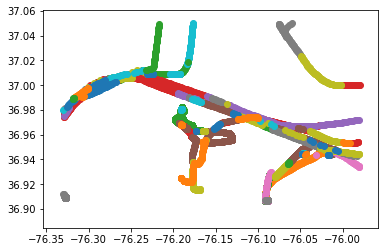

In [50]:
all_vessels = new_tracker.get_node_track()
cnames = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000','#101010','#202020','#303030','#404040','#505050','#606060','#707070','#909090']
for i in range(new_tracker.get_track_number()):
    track = all_vessels[i]
    temp_x = np.zeros(len(track))
    temp_y = np.zeros(len(track))
    counter = 0
    for element in track:
        temp_x[counter] = element.get_LON()
        temp_y[counter]= element.get_LAT()
        counter += 1
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(x,y)

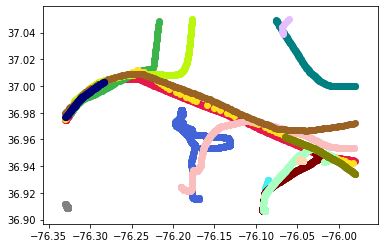

In [51]:
#Glimpse at all the vessel tracks
cnames = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000','#101010','#202020','#303030','#404040','#505050','#606060','#707070','#909090']
for vid in range(low_bound, high_bound+1):
    sample = dataset_3[dataset_3.VID == vid]
    temp_x = [element.LAT for element in sample.itertuples()]
    temp_y = [element.LON for element in sample.itertuples()]
    x = np.array(temp_x)
    y = np.array(temp_y)
    plt.scatter(y,x, c = cnames[vid-low_bound])

In [52]:
result = new_tracker.get_tracks()
expect = tracker.get_tracks()
accuracies = []
for every_expect in expect:
    max_accuracy = 0
    count = 0
    for every_track in result:
        for every_node in every_expect:
            if every_node in every_track:
                count += 1
        accuracy = count / len(every_expect)
        count = 0
        if(accuracy > max_accuracy):
            max_accuracy = accuracy
    accuracies.append(max_accuracy)
            
        

In [53]:
print(accuracies)
print(sum(accuracies)/len(accuracies))

[0.3442340791738382, 0.3228346456692913, 0.2972972972972973, 0.47341772151898737, 0.5018208302986161, 0.29339477726574503, 0.40843373493975904, 0.3680183626625861, 0.5965346534653465, 0.45472837022132795, 0.4644808743169399, 1.0, 0.4292237442922374, 0.39436619718309857, 0.4079336885731202, 0.4929494712103408, 0.3872832369942196, 0.41935483870967744, 1.0, 0.6645161290322581]
0.48604113264123433
